In [1]:
import json

In [2]:
from sentinelhub import SentinelHubRequest, SentinelHubDownloadClient, BBox, CRS, DataCollection, MimeType, SHConfig
from sentinelhub import WmsRequest, WcsRequest
from sentinelhub import constants, CustomUrlParam
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
config = SHConfig()
config.sh_client_id = os.getenv("CLIENT_ID")
config.sh_client_secret = os.getenv("CLIENT_SECRET")

In [10]:
load_dotenv()

True

In [11]:
# path = "../data/bbox/bbox_2.json"
path = "../notebooks/bounding_boxes0.geojson"
with open(path) as file:
    data = json.load(file)

In [12]:
def getL2A():
    evalscript_true_color ="""//VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B09", "B11", "B12", "CLM", "dataMask"],
            }],
            output: {
                bands: 11
            }
        };
    }

    function evaluatePixel(sample) {
        if (sample.dataMask != 1) {
            return [99, 99, 99]
        }
        return [
            2.5 * sample.B02,
            2.5 * sample.B03,
            2.5 * sample.B04,
            2.5 * sample.B05,
            2.5 * sample.B06,
            2.5 * sample.B07,
            2.5 * sample.B8A,
            2.5 * sample.B09,
            2.5 * sample.B11,
            2.5 * sample.B12,
            sample.CLM,
        ];
    }"""


    request = SentinelHubRequest(
        data_folder = data_folder,
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order="leastCC",
    
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
    )

    image = request.get_data()[0]
    
    return image


In [13]:
def getDEM():
    evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["DEM"]
            }],
            output: {
                bands: 1,
                sampleType: "FLOAT32" 
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.DEM];
    }
    """

    request = SentinelHubRequest(
        data_folder = data_folder,
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.DEM,
                time_interval=time_interval,
                mosaicking_order="leastCC"

            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
    )

    dem = request.get_data()[0]
    return dem
# print(np.sum(image))
# image = request.get_data(save_data = True, show_progress=True)

In [75]:
time_interval = "2023-08-30", "2023-08-31"
data_folder = "../sat_imgs"
for i in tqdm(range(100)):
    coords = data['features'][99]['geometry']['coordinates'][0]
    bl = (min(row[0] for row in coords), min(row[1] for row in coords))
    tr = (max(row[0] for row in coords), max(row[1] for row in coords))
    size = (data['features'][99]['properties']['width'], data['features'][i]['properties']['height'])
    bbox = BBox((bl, tr), crs=CRS.WGS84)  
    
    image = getL2A()
    dem = getDEM()
    sub = (image[..., 3] - image[..., 2]).astype(float)
    add = (image[..., 3] + image[..., 2]).astype(float)
    ndvi = np.divide(sub, add, out = np.zeros_like(add) - 1, where = add != 0)
    ndvi = np.clip(ndvi, -1, 1)
    dem3 = dem[:, :, np.newaxis]
    ndvi3 = ndvi[:, :, np.newaxis]
    
    final_image = np.concatenate((image, dem3, ndvi3), axis = -1)
    np.save("../data/sat_imgs/{iid}.npy".format(iid = i), final_image)
#     np.save("tmp.npy", final_image)
#     break

  0%|                                                                                           | 0/100 [00:08<?, ?it/s]


In [76]:
im_rgb = image[..., [2, 1, 0]] 

im2 = image[..., 7 : 10]
clm = image[..., -1]

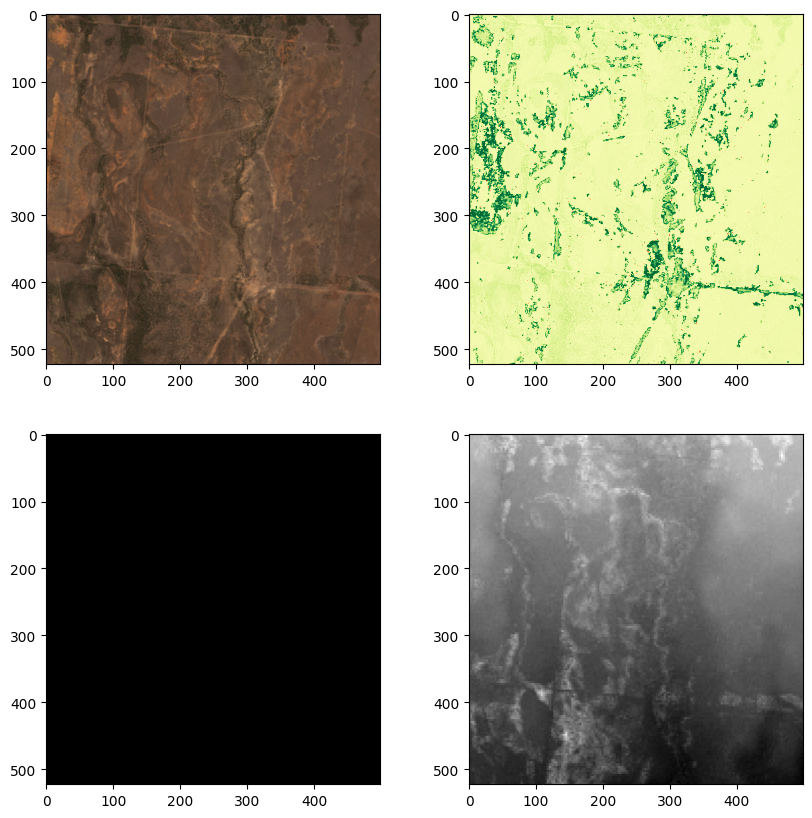

In [79]:
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(im_rgb)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(ndvi, cmap = 'RdYlGn')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(clm, cmap = 'gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(dem, cmap = 'gray')

In [31]:
np.save("../data/sat_imgs/tmp.npy", image)

In [88]:
data = np.load('../sat_imgs/1/L2A.npy')


In [205]:
from scipy.ndimage import median_filter

In [207]:
%run slope.py

In [208]:
def process_dem(dem):
    dem =  median_filter(dem, size = 5)
    dem = calcSlope(dem.reshape((1, 512, 512)),
                      np.full((512, 512), 10),
                      np.full((512, 512), 10), 
                      zScale = 1, minSlope = 0.02)
    dem = dem / 90
    dem = dem.reshape((512, 512, 1))
    dem = dem[1:-1, 1:-1]
    dem = median_filter(dem, 5)[2:-2, 2:-2]
    return dem


In [209]:
dem = process_dem(dem)

In [210]:
dem.shape

(506, 506, 1)

In [50]:
path = os.path.join("../sat_imgs", "1")

In [51]:
os.mkdir(path)

In [52]:
np.save(path + "/dem", dem)

In [47]:
for folder, _, filenames in os.walk(request.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

../sat_imgs/0a63ba069684fa673af9ea69e0cf5d8b/request.json
../sat_imgs/0a63ba069684fa673af9ea69e0cf5d8b/response.tiff
../sat_imgs/5515fc22c452136d8490bdd7c357a570/request.json
../sat_imgs/5515fc22c452136d8490bdd7c357a570/response.png
../sat_imgs/0b72b652985b4785df4400ef164c6874/request.json
../sat_imgs/0b72b652985b4785df4400ef164c6874/response.tiff


In [91]:
from datetime import datetime, timedelta

In [76]:
today = datetime.today()
formatted_date = today.strftime("%Y-%m-%d")
formatted_date

'2023-12-03'

In [77]:
inputdate = "2023-09-13"


In [88]:
dt = [int(d) for d in inputdate.split('-')]
dtt = datetime(*dt)

In [92]:
st = dtt - timedelta(days = 60)
end = dtt + timedelta(days = 60)
print(st.strftime("%Y-%m-%d"))
print(end.strftime("%Y-%m-%d"))

2023-07-15
2023-11-12


In [90]:
dem_request = WcsRequest(
                         layer='DEM', bbox=bbox,
                         resx = "10m", resy = "10m",
                         config=config,
                         image_format= MimeType.TIFF,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
dem_image_init = dem_request.get_data()[0]

TypeError: __init__() missing 1 required keyword-only argument: 'data_collection'

In [53]:
from slope import calcSlope

In [55]:
os.path.isdir(path) 

True

In [56]:
request.execute()

AttributeError: 'SentinelHubRequest' object has no attribute 'execute'